# The index alignment and data merging stage

In this section, the alignment and merging steps are presented through an example.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from eensight.config import ConfigLoader
from eensight.methods.preprocessing.validation import validate_dataset
from eensight.methods.preprocessing.alignment import (
    get_hourly_timesteps, 
    get_time_step,
    _align_by_value,
    _align_by_distance,
    align_to_index,
    merge_data_list
)
from eensight.settings import PROJECT_PATH
from eensight.utils import load_catalog

%matplotlib inline

## Load a dataset

First, we load the catalog for one of the available datasets (the one with `site_id="b05"`):

In [29]:
catalog = load_catalog(store_uri="../../../data", site_id="b05", namespace="train")

Get and validate the raw input data:

In [30]:
features = catalog.load("train.input-features")
labels = catalog.load("train.input-labels")

In [31]:
def validate(data, feature_name):
    for name, load_fn in data.items():
        if name.split(".")[0] == feature_name:
            return validate_dataset(load_fn())


In [32]:
consumption = validate(labels, "consumption")
temperature = validate(features, "temperature")
holidays = validate(features, "holidays")

Check that the labels dataset has only one time step with duration that is less than one (1) day. 

In [33]:
assert len(get_hourly_timesteps(consumption.index)) == 1

If the labels dataset has indeed only one time step, its index becomes the primary index for all features. Alignment is needed only when features have different time steps than the labels (for instance, hourly temperature data, but 15-minute interval consumption data).    

This is the case for this dataset:

In [34]:
print(f"Time step of consumption data: {get_time_step(consumption.index)}")
print(f"Time step of temperature data: {get_time_step(temperature.index)}")
print(f"Time step of holiday data: {get_time_step(holidays.index)}")

Time step of consumption data: 0 days 00:15:00
Time step of temperature data: 0 days 00:30:00
Time step of holiday data: 1 days 00:00:00


Index alignment is performed by the `eensight.methods.preprocessing.alignment.align_to_index` function.

For data that is *numerical*, `align_to_index` provides two (2) approaches for alignment. The first approach interpolates the data to match the primary index, the second matches the primary index on the nearest key of the feature's index. 

Both approaches are controlled by a `tolerance` parameter (`pandas.Timedelta`): 

* For the first approach, `tolerance` dictates how far interpolation can reach. As an example, outdoor temperature changes slowly, so interpolating over 2 or 3 hours should not be a problem. Other features may change faster, and a shorter `tolerance` may be needed for them. 


* For the second approach, `tolerance` is the maximum time distance to match a timestamp of the input dataframe with a timestamp in the primary index.

**Alignment by interpolation:**

In [35]:
temperature_aligned = align_to_index(
    temperature, 
    consumption.index, 
    mode="value", 
    tolerance=pd.Timedelta(minutes=60*3)
)

In [36]:
assert temperature_aligned.index.equals(consumption.index)

In [37]:
original = temperature.resample("1H").mean()

aligned = temperature_aligned.resample("1H").mean()
differences = original - aligned

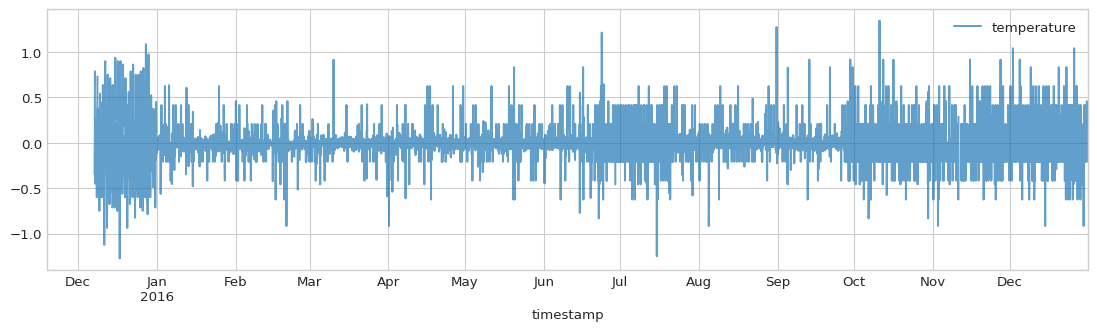

In [38]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    differences.loc[aligned.index].plot(ax=ax, alpha=0.7)

**Alignment by timestamp distance:**

In [39]:
temperature_aligned = align_to_index(
    temperature, 
    consumption.index, 
    mode="distance", 
    tolerance=pd.Timedelta(minutes=60*3)
)

In [40]:
aligned = temperature_aligned.resample("1H").mean()
differences = original - aligned

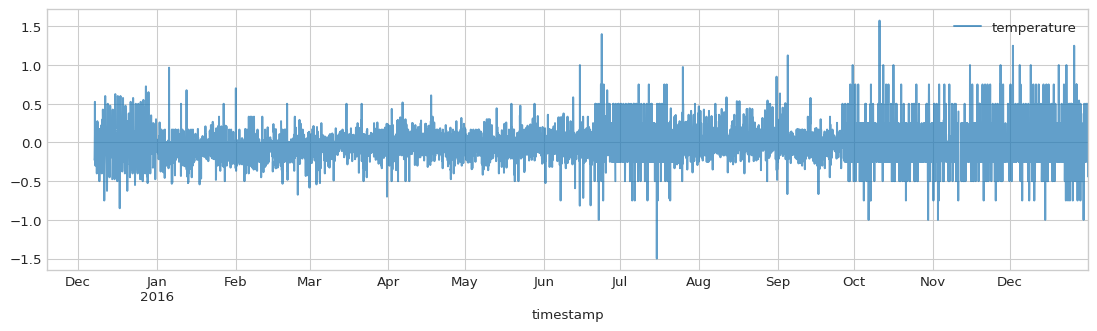

In [41]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    differences.loc[aligned.index].plot(ax=ax, alpha=0.7)

Although the differences are small, alignment by interpolation is more accurate than alignment by timestamp distance. 

For data that is both *numerical* and *cumulative*, alignment is done by first calculating the cumulative sum of the feature to align, then applying the alignment method (by interpolation or by distance), and finally calculating the first discrete differences so that to reverse the cumulative sum transformation. 

For demonstration purposes, we can align the consumption (which is *numerical* and *cumulative*) to the index of the temperature:  

In [42]:
consumption_aligned = align_to_index(
    consumption, 
    temperature.index, 
    mode="value", 
    cumulative=True,
    tolerance=pd.Timedelta(minutes=60)
)

[11/07/22 14:38:44] INFO     Cumulative feature consumption normalized by time step length.        ]8;id=109319;file://C:\Users\spapadelis\Desktop\eensight\src\eensight\methods\preprocessing\alignment.py\alignment.py]8;;\:]8;id=823356;file://C:\Users\spapadelis\Desktop\eensight\src\eensight\methods\preprocessing\alignment.py#194\194]8;;\

**Important Note!**
      
> When `align_to_index` aligns features to the labels' index, any feature that is both **numerical** and **cumulative** will be **normalized** by dividing its value at any given timestamp by the number of minutes between this timestamp and the immediately preceding one. This is done so that to avoid misleading values when the primary index has time gaps.

In [43]:
original = consumption.div(
                consumption.index.to_series().diff().map(lambda x: x.total_seconds() / 60),
                axis=0
)

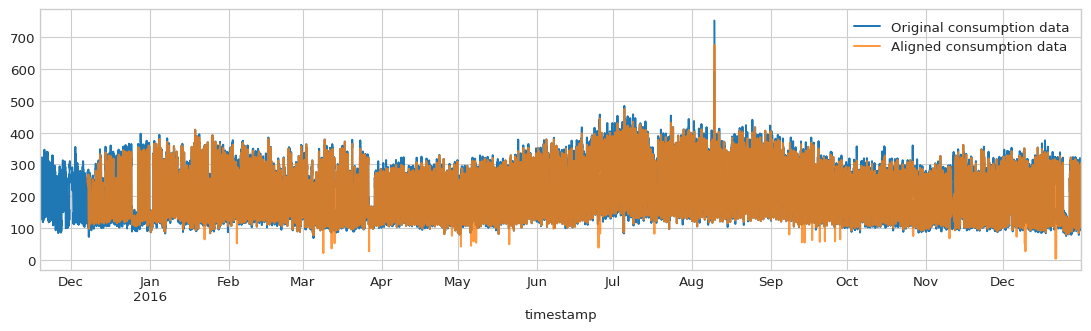

In [44]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    original.plot(ax=ax)
    consumption_aligned.plot(ax=ax, alpha=0.8)
    ax.legend(["Original consumption data", "Aligned consumption data"])

Alignment of categorical features is always done by timestamp distance.

`align_to_index` can align daily data to sub-daily indices:

In [45]:
holidays_aligned = align_to_index(holidays, consumption.index)

This task does not need a `tolerance` parameter. The daily data is just repeated for every timestamp that corresponds to the relevant day: 

In [46]:
holidays_aligned[holidays_aligned.index.date == holidays.index[-1].date()]

,holiday
timestamp,
2016-12-26 00:00:00,St Stephen's Day
2016-12-26 00:15:00,St Stephen's Day
2016-12-26 00:30:00,St Stephen's Day
2016-12-26 00:45:00,St Stephen's Day
2016-12-26 01:00:00,St Stephen's Day
...,...
2016-12-26 22:45:00,St Stephen's Day
2016-12-26 23:00:00,St Stephen's Day
2016-12-26 23:15:00,St Stephen's Day


Finally, aligning sub-daily data to a daily index is not supported. This should be part of a feature engineering process and not a data preprocessing one.

The function `eensight.methods.preprocessing.alignment.merge_data_list` aligns all feature dataframes in a provided list if alignment is needed, and merges them into one features dataset:

In [47]:
mode = {"temperature": "value"}
tolerance = {"temperature": pd.Timedelta(minutes=60*3)}

merged = merge_data_list([temperature, holidays], 
                         primary=consumption.index, 
                         mode=mode, 
                         tolerance=tolerance
)

In [48]:
assert merged.index.equals(consumption.index)

## Parameters

The parameters of this stage - as they can be found in the `eensight/conf/base/parameters/preprocess.yml` file are:

In [69]:
params = ConfigLoader(PROJECT_PATH / "conf").get("parameters*", "parameters*/**", "**/parameters*")

In [71]:
{"alignment": params["alignment"]}

{
    'alignment': {
        'mode': {'temperature': 'value'},
        'tolerance': {'temperature': 180},
        'cumulative': {'temperature': False, 'consumption': True}
    }
}

These parameters can be changed from the command line. As an example, suppose that there is an additional feature `solar_radiation` and maybe `tolerance` for solar radiation should be only 15 minutes. In such a case, the following option can be passed to the command line:

```
--param alignment.tolerance.solar_radiation=15
```

This will work because `eensight` does under the hood something like this:

In [74]:
{"alignment": OmegaConf.to_container(
                OmegaConf.merge(
                    OmegaConf.create(params), 
                    OmegaConf.from_dotlist(["alignment.tolerance.solar_radiation=15"])
                    )
               )["alignment"]
}

{
    'alignment': {
        'mode': {'temperature': 'value'},
        'tolerance': {'temperature': 180, 'solar_radiation': 15},
        'cumulative': {'temperature': False, 'consumption': True}
    }
}

-----------------